Original implementation by Utku Ozbulak attacking AlexNet trained on ImageNet
https://github.com/utkuozbulak/pytorch-cnn-adversarial-attacks

CIFAR10 EfficientNet adaptation by Sean Johnson

In [1]:
import os
import numpy as np
import time

import torch
from torch import nn
from torch.autograd import Variable

import pbd
import torchvision
import torchvision.transforms as transforms
from models import *

from matplotlib import pyplot as plt

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=False, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = EfficientNetB0()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)

PATH = './data/ckpt.pth'

checkpoint = torch.load(PATH)
_ = net.load_state_dict(checkpoint['net'])

In [4]:
def preprocess(image):
    mean = [0.4914, 0.48216, 0.44653]
    std = [0.24703, 0.24349, 0.26159]
    npimg = image.cpu().detach().numpy()
    npimg = npimg[0]
    for channel in range(3):
        npimg[channel] -= mean[channel]
        npimg[channel] /= std[channel]
    npimg = np.tile(npimg, [1,1,1,1])
    ptimg = torch.from_numpy(npimg)
    processed_image = Variable(ptimg.cuda(), requires_grad=True)
    return processed_image

def unprocess(image):
    mean = [0.4914, 0.48216, 0.44653]
    std = [0.24703, 0.24349, 0.26159]
    npimg = image.cpu().detach().numpy()
    npimg = npimg[0]
    transposed = np.transpose(npimg,(1,2,0))
    
    for channel in range(3):
        npimg[channel] *= std[channel]
        npimg[channel] += mean[channel]
    npimg[npimg > 1] = 1
    npimg[npimg < 0] = 0
    npimg = np.tile(npimg, [1,1,1,1])
    ptimg = torch.from_numpy(npimg)
    unprocessed_image = Variable(ptimg.cuda(), requires_grad=True)
    return unprocessed_image
              
def viewable(pyten):
    npimg = pyten.cpu().detach().numpy()
    npimg = npimg[0]
    npimg = np.transpose(npimg, (1,2,0))
    return npimg

def show(image):
    plt.imshow(image)
    plt.show()
    
def scale(X, x_min, x_max):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom

def classify(image, verbose = False):
    net.eval()
    predictions = net(preprocess(image))
    _, predicted = predictions.data.max(1)
    confidence = nn.functional.softmax(predictions, dim=1)[0][predicted].data.cpu().numpy()[0]
    predicted = predicted.cpu().numpy()[0]
    if verbose: print("Predicted %s with confidence %f" % (classes[predicted], confidence))
    unprocess(image)
    return predicted, confidence

In [5]:
class FastGradientSignUntargeted():
    """
        Fast gradient sign untargeted adversarial attack, minimizes the initial class activation
        with iterative grad sign updates
    """
    def __init__(self, model, device, alpha):
        self.model = model
        self.model.eval()
        self.device = device
        # Movement multiplier per iteration
        self.alpha = alpha

    def generate(self, original_image, im_label, verbose = False, visualization = False):
        t0 = time.time()
        # Define loss functions
        ce_loss = nn.CrossEntropyLoss()
        
        # Image Preprocessing:
        processed_image = preprocess(original_image)
        
        
        # Start iteration
        for i in range(15):
            #print('Iteration:', str(i))
            # zero_gradients(x)
            # Zero out previous gradients
            # Can also use zero_gradients(x)
            #processed_image.grad = None
            processed_image.grad = None
            im_label = im_label.cuda()
            # Forward pass
            out = self.model(processed_image)
            # Calculate CE loss
            pred_loss = ce_loss(out, im_label)
            # Do backward pass
            pred_loss.backward()
            # Create Noise
            # Here, processed_image.grad.data is also the same thing is the backward gradient from
            # the first layer, can use that with hooks as well
            adv_noise = self.alpha * torch.sign(processed_image.grad.data)
            # Add Noise to processed image
            processed_image.data = processed_image.data + adv_noise
            
            # Confirming if the image is indeed adversarial with added noise
            predicted, confidence = classify(unprocess(processed_image), verbose = False)
            if predicted != im_label.cpu().numpy()[0]: break
        
        return_image = unprocess(processed_image)
        return_image = return_image.cpu().detach()
        if verbose: 
            t1 = time.time()
            unprocess(original_image)
            original_class, _ = classify(original_image)
            print("Iterations: %d\nElapsed time: %f seconds" % (i+1, t1-t0))
            print("Original image classified as %s; with adversarial noise classified as %s, confidence=%f\n" \
                  % (classes[original_class], classes[predicted], confidence))
        if visualization: 
            print("Original Image")
            show(viewable(original_image))
            print("Adversarial Image")
            show(viewable(return_image))
            print("Adversarial Noise")
            noise_image = original_image - return_image
            npimg = noise_image.cpu().detach().numpy()
            npimg = npimg[0]
            npimg = scale(npimg, 0, 1)
            npimg = np.transpose(npimg, (1,2,0))
            plt.imshow(npimg)
            plt.show()
        
        return return_image

Attack demonstration:

Iterations: 1
Elapsed time: 0.057631 seconds
Original image classified as frog; with adversarial noise classified as deer, confidence=0.777271

Original Image


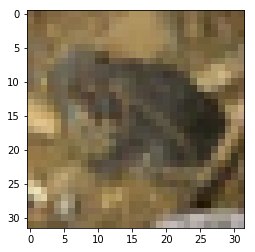

Adversarial Image


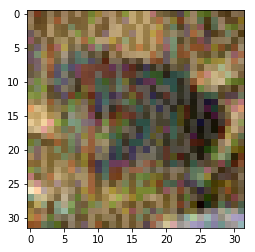

Adversarial Noise


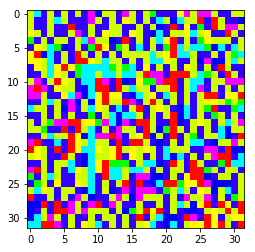

In [8]:
FGS_untargeted = FastGradientSignUntargeted(net, device, 0.3)
dataiter = iter(trainloader)
for _ in range(23):
    dataiter.next()
image, label = dataiter.next()

adversarial_image = FGS_untargeted.generate(image, label, verbose=True, visualization = True)
#_ = classify(adversarial_image, verbose = True)

Attacking CIFAR10 training set:

In [9]:
# generate adversarial equivalent of CIFAR10 training set
# elapsed time = 4476.704 on AWS EC2 p2.xlarge instance
if True:
    x_train = np.array([0.0])
    x_train = np.tile(x_train, [50000, 32, 32, 3])
    y_train = np.array([0.])
    y_train = np.tile(y_train, [50000, 10])

    t0 = time.time()
    dataiter = iter(trainloader)
    for i in range(50000):
        image, label = dataiter.next()
        adversarial_image = FGS_untargeted.generate(image, label)
        x_train[i] = viewable(adversarial_image)
        y_train[i][label[0]] = 1
        if i % 1000 == 0:
            print("%f done" % (i/50000.0))
    t1 = time.time()
    print("Elapsed time: %f" % (t1-t0))
    
    np.save("./data/x_train_adversarial", x_train)
    np.save("./data/y_train_adversarial", y_train)

0.000000 done
0.020000 done
0.040000 done
0.060000 done
0.080000 done
0.100000 done
0.120000 done
0.140000 done
0.160000 done
0.180000 done
0.200000 done
0.220000 done
0.240000 done
0.260000 done
0.280000 done
0.300000 done
0.320000 done
0.340000 done
0.360000 done
0.380000 done
0.400000 done
0.420000 done
0.440000 done
0.460000 done
0.480000 done
0.500000 done
0.520000 done
0.540000 done
0.560000 done
0.580000 done
0.600000 done
0.620000 done
0.640000 done
0.660000 done
0.680000 done
0.700000 done
0.720000 done
0.740000 done
0.760000 done
0.780000 done
0.800000 done
0.820000 done
0.840000 done
0.860000 done
0.880000 done
0.900000 done
0.920000 done
0.940000 done
0.960000 done
0.980000 done
Elapsed time: 2585.002736


In [10]:
# load adversarial training set
if False:
    x_train = np.load("./data/x_train_adversarial.npy")
    y_train = np.load("./data/y_train_adversarial.npy")

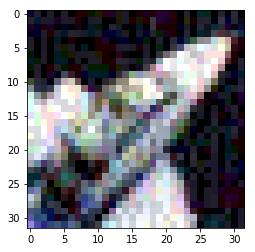

ship
Predicted deer with confidence 0.239779


In [11]:
# test adversarial images
idx = 20000
show(x_train[idx])
print(classes[y_train[idx].argmax()])
npimg = np.transpose(x_train[idx],(2,0,1))
npimg = np.tile(npimg, [1,1,1,1])
ptimg = torch.from_numpy(npimg)
ptimg = Variable(ptimg.cuda(), requires_grad=True)
ptimg = ptimg.float()
_ = classify(ptimg, verbose = True)

In [12]:
#Elapsed time: 871.355 on AWS EC2 p2.xlarge instance
if True:
    x_test = np.array([0.0])
    x_test = np.tile(x_test, [10000, 32, 32, 3])
    y_test = np.array([0.])
    y_test = np.tile(y_test, [10000, 10])
    
    t0 = time.time()
    dataiter = iter(testloader)
    for i in range(10000):
        image, label = dataiter.next()
        adversarial_image = FGS_untargeted.generate(image, label)
        x_test[i] = viewable(adversarial_image)
        y_test[i][label[0]] = 1
        if i % 1000 == 0:
            print("%f done" % (i/10000.0))
    t1 = time.time()
    print("Elapsed time: %f" % (t1-t0))
    
    np.save("./data/x_test_adversarial", x_test)
    np.save("./data/y_test_adversarial", y_test)

0.000000 done
0.100000 done
0.200000 done
0.300000 done
0.400000 done
0.500000 done
0.600000 done
0.700000 done
0.800000 done
0.900000 done
Elapsed time: 513.311188


In [13]:
# load adversarial training set
if False:
    x_test = np.load("./data/x_test_adversarial.npy")
    y_test = np.load("./data/y_test_adversarial.npy")

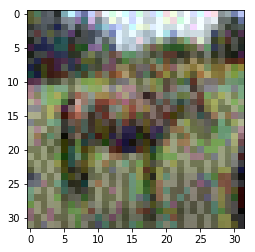

horse
Predicted deer with confidence 0.772323


In [14]:
# test adversarial images
idx = 9999
show(x_test[idx])
print(classes[y_test[idx].argmax()])
npimg = np.transpose(x_test[idx],(2,0,1))
npimg = np.tile(npimg, [1,1,1,1])
ptimg = torch.from_numpy(npimg)
ptimg = Variable(ptimg.cuda(), requires_grad=True)
ptimg = ptimg.float()
_ = classify(ptimg, verbose = True)